In [1]:
## Import Python libraries ## 

import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import xarray as xr


%matplotlib inline
%reload_ext xsimlab.ipython


import fastscape

from orographic_precipitation.fastscape_ext import precip_model
from fastscape.processes import Bedrock


In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [3]:
## Build xarray-simlab model ##
SouthernAndesLEM = precip_model
SouthernAndesLEM = precip_model.drop_processes(['init_topography'])
SouthernAndesLEM = SouthernAndesLEM.update_processes({'bedrock': Bedrock})

SouthernAndesLEM

<xsimlab.Model (17 processes, 26 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fallout time
    nm                     [in] moist stability frequency
    hw  

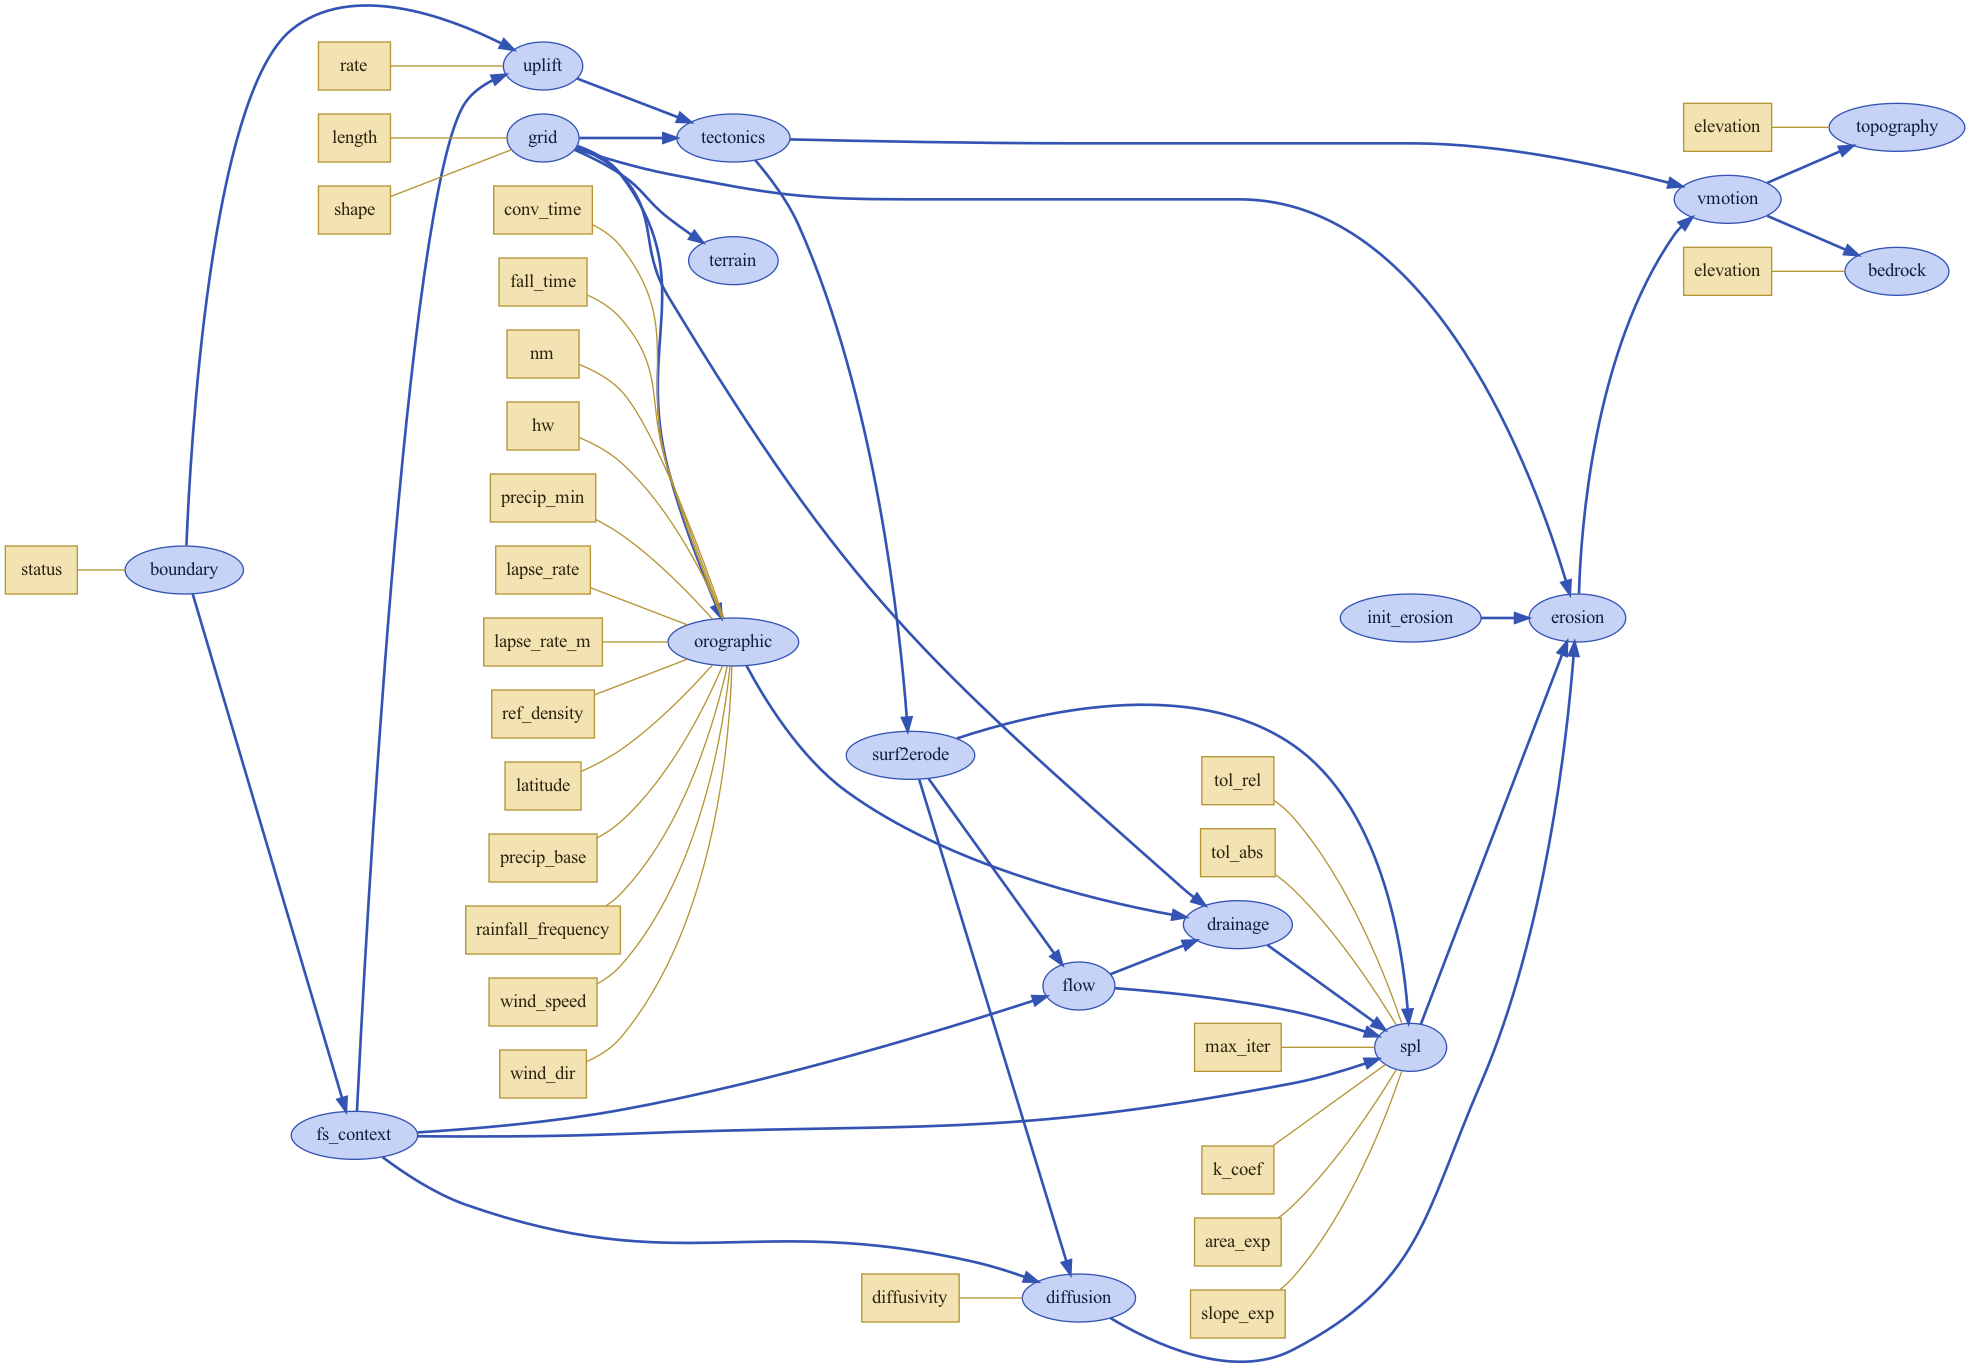

In [4]:
## Visualise xarray-simlab ##
SouthernAndesLEM.visualize(show_inputs='True')

In [5]:
## Model dimensions/grid dimensions ##
nx = 100
ny = 100
nn = nx * ny

xl = 100.e3
yl = 100.e3

BoundaryCondition = ['looped', 'looped', 'fixed_value', 'fixed_value']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

# EndTime = 1e6
# TimeSteps = 1001
ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Tectonics ##
k_coef= 2.5e-5
area_exp = 0.4
slope_exp = 1.0
diffusion_diffusivity = 0.


## Orographic ##
lapse_rate = -5.4 #mean lapse rate of area not too far away 
lapse_rate_m = -6.5 #left default
ref_density = 7.4e-3  #left default
rainfall_frequency = 295 #calculated based on weather days plot from website
latitude = 46  #latitude around the area north in the Patagonian Andes
precip_base =  1e-4 #not sure if I should change this or not
wind_speed = 10 #base to start with 
wind_dir = 270  # estimated direction given weather info 
precip_min = 0.1 #chatgpt value so could be wrong
conv_time = 2000 #2000 thesis value
fall_time = 2000 #2000 thesis value
nm = 0.003  #0.03 #thesis value
hw = 5000  #


## Initial topography ##
WhiteNoiseLevel = 50 # in [m], amplitude of noise

## Seed for Reproducibility ##
RandomSeed = 1410

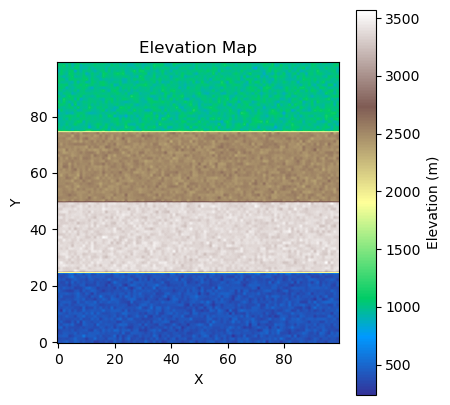

In [6]:
# Total number of nodes
nn = nx * ny  # Total number of nodes
InitialTopography = np.zeros(nn)  # Initialize an array to store elevations

# Assign elevations based on node indices (using slicing and grid structure)
InitialTopography[:int(0.25 * nn)] = 400    # First 25% of nodes
InitialTopography[int(0.25 * nn):int(0.5 * nn)] = 3375  # Next 25% of nodes
InitialTopography[int(0.5 * nn):int(0.75 * nn)] = 2500  # Next 25% of nodes
InitialTopography[int(0.75 * nn):] = 1000  # Last 25% of nodes

# Adding random noise to the elevations
np.random.seed(42)  # For reproducibility
WhiteNoiseLevel = 50  # Standard deviation of noise
Noise = np.random.normal(0, WhiteNoiseLevel, nn)
InitialTopography += Noise  # Add noise to the elevations

# Reshape the 1D array to 2D with shape (ny, nx)
InitialTopography = InitialTopography.reshape((ny, nx))

# Plot the reshaped topography
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(InitialTopography, cmap='terrain', origin='lower')
plt.colorbar(label='Elevation (m)')
plt.title('Elevation Map')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()


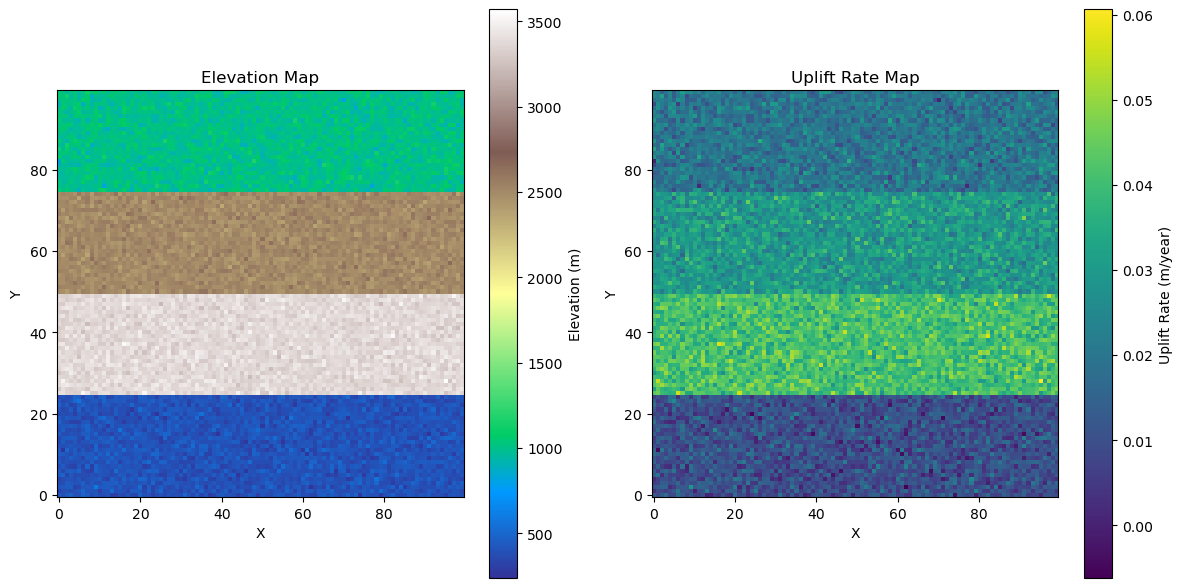

In [7]:
# Define first stage uplift rates for each region
UpliftRates = np.zeros(nn)  # Initialize uplift rates array

# Assign uplift rates to regions (using slicing or fractions of the total nodes)
UpliftRates[:int(0.25 * nn)] = 0.01    # First 25% of nodes
UpliftRates[int(0.25 * nn):int(0.5 * nn)] = 0.041  # Next 25% of nodes
UpliftRates[int(0.5 * nn):int(0.75 * nn)] = 0.03  # Next 25% of nodes
UpliftRates[int(0.75 * nn):] = 0.02  # Last 25% of nodes

# Adding random noise to the uplift rates for realism (optional)
np.random.seed(42)  # For reproducibility
UpliftNoise = np.random.normal(0, 0.005, nn)  # Small noise in uplift rates
UpliftRates += UpliftNoise  # Add noise to the uplift rates

# Reshape the 1D array to 2D with shape (ny, nx)
InitialTopography_2D = InitialTopography.reshape((ny, nx))
UpliftRates_2D = UpliftRates.reshape((ny, nx))

# Plotting the elevation map and uplift rate map
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Elevation Map
plt.subplot(1, 2, 1)
plt.imshow(InitialTopography_2D, cmap='terrain', origin='lower')
plt.colorbar(label='Elevation (m)')
plt.title('Elevation Map')
plt.xlabel('X')
plt.ylabel('Y')

# Plot Uplift Rate Map
plt.subplot(1, 2, 2)
plt.imshow(UpliftRates_2D, cmap='viridis', origin='lower')
plt.colorbar(label='Uplift Rate (m/year)')
plt.title('Uplift Rate Map')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()


In [8]:
## Set up input parameters for xarray-simlab model ##
in_ds_S1 = xs.create_setup(
    model = SouthernAndesLEM,
    clocks={
        'time': ModelTime_1,
        'output': ModelTime_1[::PlotStep]
    },
    master_clock='time',
    input_vars={
        'grid': {
            'shape': [nx, ny],
            'length': [xl, yl],
        },
         'boundary': {
            'status': BoundaryCondition
        },
        'topography': {
            'elevation': InitialTopography_2D,
        },
        'bedrock': {
            'elevation': InitialTopography_2D,
        },
        'uplift': {
            'rate': UpliftRates_2D,
        },
        'spl': {
            'k_coef': k_coef,
            'area_exp': area_exp,
            'slope_exp': slope_exp,
        },
        'diffusion': {
            'diffusivity': diffusion_diffusivity,
        },
        'orographic': {
            'lapse_rate': lapse_rate,
            'lapse_rate_m': lapse_rate_m,
            'ref_density': ref_density, 
            'rainfall_frequency': rainfall_frequency,
            'latitude': latitude,
            'precip_base': precip_base,  
            'wind_speed': wind_speed,   
            'wind_dir': wind_dir,
            'precip_min': precip_min,  
            'conv_time': conv_time,            
            'fall_time': fall_time,         
            'nm': nm,                                
            'hw': hw,
        },
    },
    output_vars={
        'topography__elevation': 'time',
        'orographic__precip_rate': 'time'
    }
)

in_ds_S1

<xarray.Dataset>
Dimensions:                         (time: 10001, output: 101, shape_yx: 2,
                                     border: 4, y: 100, x: 100)
Coordinates:
  * time                            (time) float64 0.0 500.0 ... 5e+06 5e+06
  * output                          (output) float64 0.0 5e+04 ... 5e+06
Dimensions without coordinates: shape_yx, border, y, x
Data variables: (12/26)
    spl__tol_rel                    float64 0.0001
    spl__tol_abs                    float64 0.0001
    spl__max_iter                   int64 100
    grid__shape                     (shape_yx) int64 100 100
    grid__length                    (shape_yx) float64 1e+05 1e+05
    boundary__status                (border) <U11 'looped' ... 'fixed_value'
    ...                              ...
    orographic__wind_dir            int64 270
    orographic__precip_min          float64 0.1
    orographic__conv_time           int64 2000
    orographic__fall_time           int64 2000
    orographic__nm                  float64 0.003
    orographic__hw                  int64 5000

In [9]:
with xs.monitoring.ProgressBar():
    out_ds_S1 = in_ds_S1.xsimlab.run(model=SouthernAndesLEM)
    
out_ds_S1

             0% | initialize 

<xarray.Dataset>
Dimensions:                         (y: 100, x: 100, border: 4, shape_yx: 2,
                                     time: 10001, output: 101)
Coordinates:
  * border                          (border) object 'left' 'right' ... 'bottom'
  * output                          (output) float64 0.0 5e+04 ... 5e+06
  * time                            (time) float64 0.0 500.0 ... 5e+06 5e+06
  * x                               (x) float64 0.0 1.01e+03 ... 9.899e+04 1e+05
  * y                               (y) float64 0.0 1.01e+03 ... 9.899e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables: (12/27)
    bedrock__elevation              (y, x) float64 424.8 393.1 ... 1.032e+03
    boundary__status                (border) <U11 'looped' ... 'fixed_value'
    diffusion__diffusivity          float64 0.0
    grid__length                    (shape_yx) float64 1e+05 1e+05
    grid__shape                     (shape_yx) int64 100 100
    orographic__conv_time           int64 2000
    ...                              ...
    spl__max_iter                   int64 100
    spl__slope_exp                  float64 1.0
    spl__tol_abs                    float64 0.0001
    spl__tol_rel                    float64 0.0001
    topography__elevation           (time, y, x) float64 424.8 ... 1.032e+03
    uplift__rate                    (y, x) float64 0.01248 0.009309 ... 0.02322

In [10]:
out_ds_S1.mean(dim='x')

<xarray.Dataset>
Dimensions:                         (y: 100, border: 4, shape_yx: 2,
                                     time: 10001, output: 101)
Coordinates:
  * border                          (border) object 'left' 'right' ... 'bottom'
  * output                          (output) float64 0.0 5e+04 ... 5e+06
  * time                            (time) float64 0.0 500.0 ... 5e+06 5e+06
  * y                               (y) float64 0.0 1.01e+03 ... 9.899e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables: (12/27)
    bedrock__elevation              (y) float64 394.8 401.1 ... 999.2 1e+03
    boundary__status                (border) <U11 'looped' ... 'fixed_value'
    diffusion__diffusivity          float64 0.0
    grid__length                    (shape_yx) float64 1e+05 1e+05
    grid__shape                     (shape_yx) int64 100 100
    orographic__conv_time           float64 2e+03
    ...                              ...
    spl__max_iter                   float64 100.0
    spl__slope_exp                  float64 1.0
    spl__tol_abs                    float64 0.0001
    spl__tol_rel                    float64 0.0001
    topography__elevation           (time, y) float64 394.8 401.1 ... 1e+03
    uplift__rate                    (y) float64 0.009481 0.01011 ... 0.02003

In [11]:
print(out_ds_S1)


<xarray.Dataset>
Dimensions:                         (y: 100, x: 100, border: 4, shape_yx: 2,
                                     time: 10001, output: 101)
Coordinates:
  * border                          (border) object 'left' 'right' ... 'bottom'
  * output                          (output) float64 0.0 5e+04 ... 5e+06
  * time                            (time) float64 0.0 500.0 ... 5e+06 5e+06
  * x                               (x) float64 0.0 1.01e+03 ... 9.899e+04 1e+05
  * y                               (y) float64 0.0 1.01e+03 ... 9.899e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables: (12/27)
    bedrock__elevation              (y, x) float64 424.8 393.1 ... 1.032e+03
    boundary__status                (border) <U11 'looped' ... 'fixed_value'
    diffusion__diffusivity          float64 0.0
    grid__length                    (shape_yx) float64 1e+05 1e+05
    grid__shape                     (shape_yx) int64 100 100
    orographic__conv_time           int64 2

In [12]:
import hvplot.xarray  # Import hvplot specifically for xarray integration

# Assuming `out_ds_S1` is an xarray Dataset and has 'topography__elevation' as a data variable
out_ds_S1['topography__elevation'].hvplot.image(x='x', y='y',
                                                 cmap='viridis',
                                                 groupby='time')


BokehModel(combine_events=True, render_bundle={'docs_json': {'9f42558e-c5cc-482a-82e4-a795d6544953': {'version…

In [13]:
import hvplot.xarray

out_ds_S1.topography__elevation.hvplot.image(dim='x', y='y',
                                          cmap='viridis',
                                          groupby='time')

BokehModel(combine_events=True, render_bundle={'docs_json': {'d2adef52-9494-4fb5-8e9e-1b7e0e2024bd': {'version…

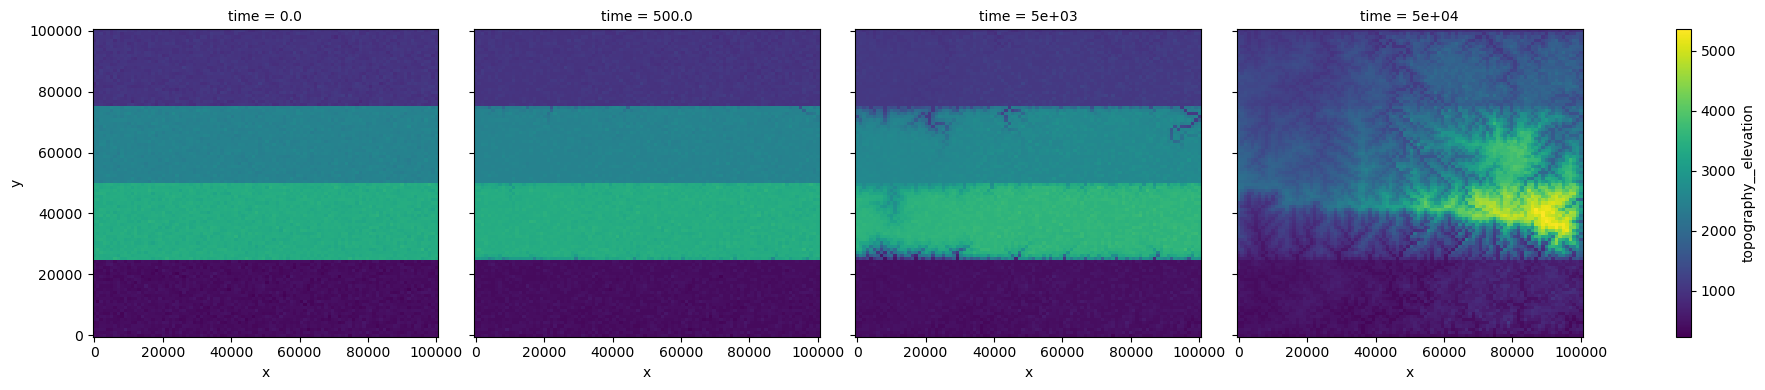

In [14]:
out_ds_S1.topography__elevation.isel(time=[0,1,10,100]).plot(col='time',figsize=(20, 4))
plt.show()

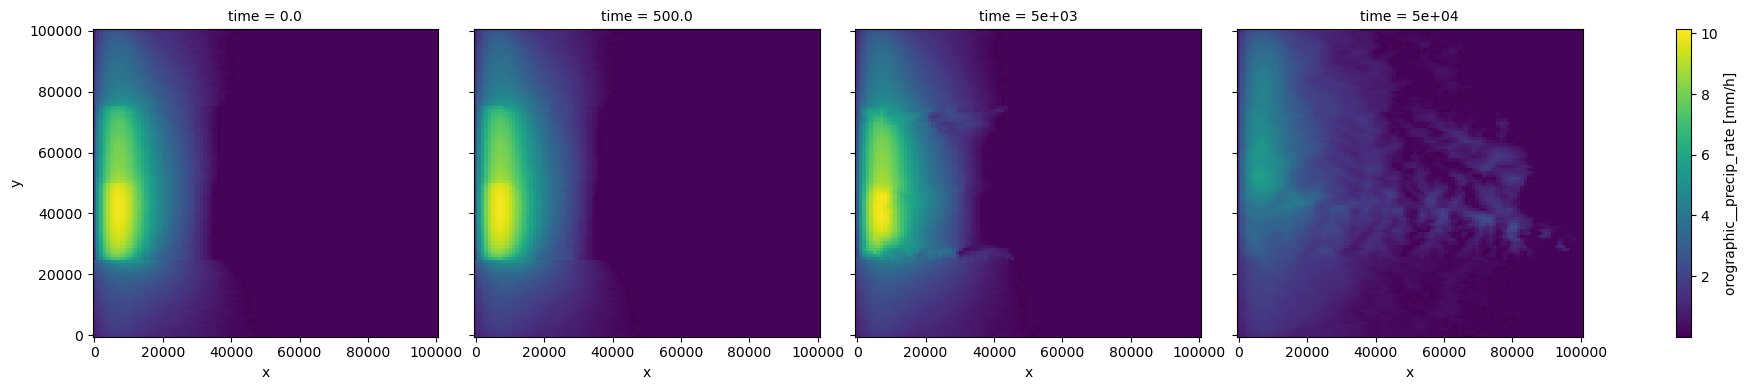

In [15]:
out_ds_S1.orographic__precip_rate.isel(time=[0,1,10,100]).plot(col='time',figsize=(20, 4))
plt.show()

In [16]:
print(out_ds_S1)


<xarray.Dataset>
Dimensions:                         (y: 100, x: 100, border: 4, shape_yx: 2,
                                     time: 10001, output: 101)
Coordinates:
  * border                          (border) object 'left' 'right' ... 'bottom'
  * output                          (output) float64 0.0 5e+04 ... 5e+06
  * time                            (time) float64 0.0 500.0 ... 5e+06 5e+06
  * x                               (x) float64 0.0 1.01e+03 ... 9.899e+04 1e+05
  * y                               (y) float64 0.0 1.01e+03 ... 9.899e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables: (12/27)
    bedrock__elevation              (y, x) float64 424.8 393.1 ... 1.032e+03
    boundary__status                (border) <U11 'looped' ... 'fixed_value'
    diffusion__diffusivity          float64 0.0
    grid__length                    (shape_yx) float64 1e+05 1e+05
    grid__shape                     (shape_yx) int64 100 100
    orographic__conv_time           int64 2

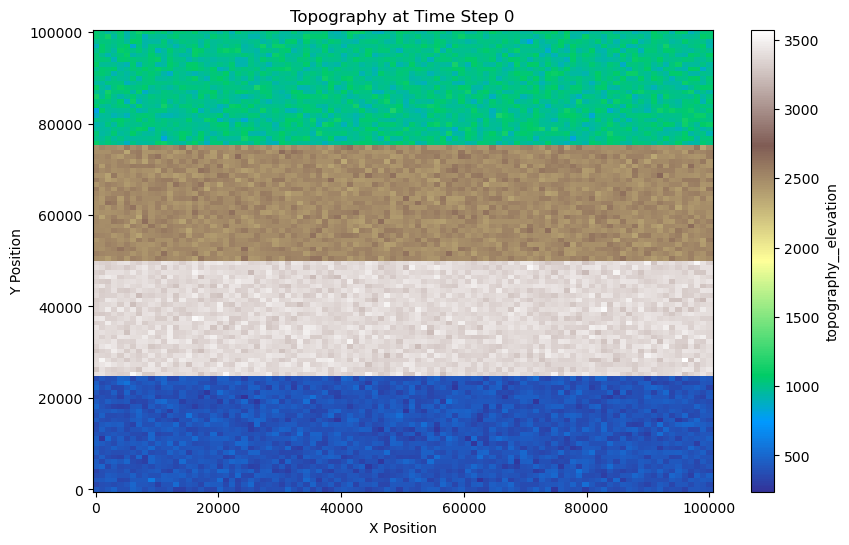

In [17]:
import matplotlib.pyplot as plt

# Select a time step (e.g., the first one)
time_step = 0
elevation = out_ds_S1['topography__elevation'].isel(time=time_step)

# Create the plot
plt.figure(figsize=(10, 6))
elevation.plot(cmap='terrain')  # xarray's plot method
plt.title(f'Topography at Time Step {time_step}')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


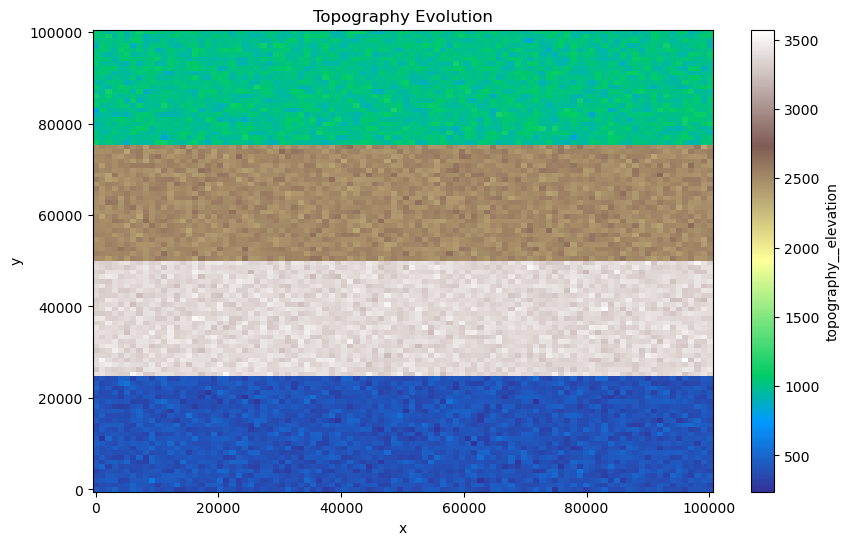

In [18]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 6))

# Initialize the plot
elevation = out_ds_S1['topography__elevation'].isel(time=0)
im = elevation.plot.imshow(ax=ax, cmap='terrain', add_colorbar=True)
title = ax.set_title('Topography Evolution')

# Update function for animation
def update(frame):
    ax.clear()
    elevation = out_ds_S1['topography__elevation'].isel(time=frame)
    elevation.plot.imshow(ax=ax, cmap='terrain', add_colorbar=False)
    ax.set_title(f'Topography at Time Step {frame}')

# Create the animation
time_steps = len(out_ds_S1['time'])
ani = FuncAnimation(fig, update, frames=time_steps, interval=200)
plt.show()


In [19]:
from ipywidgets import interact
import matplotlib.pyplot as plt

def plot_elevation(time_step):
    elevation = out_ds_S1['topography__elevation'].isel(time=time_step)
    plt.figure(figsize=(10, 6))
    elevation.plot(cmap='terrain')
    plt.title(f'Topography at Time Step {time_step}')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

interact(plot_elevation, time_step=(0, len(out_ds_S1['time']) - 1))


interactive(children=(IntSlider(value=5000, description='time_step', max=10000), Output()), _dom_classes=('wid…

<function __main__.plot_elevation(time_step)>

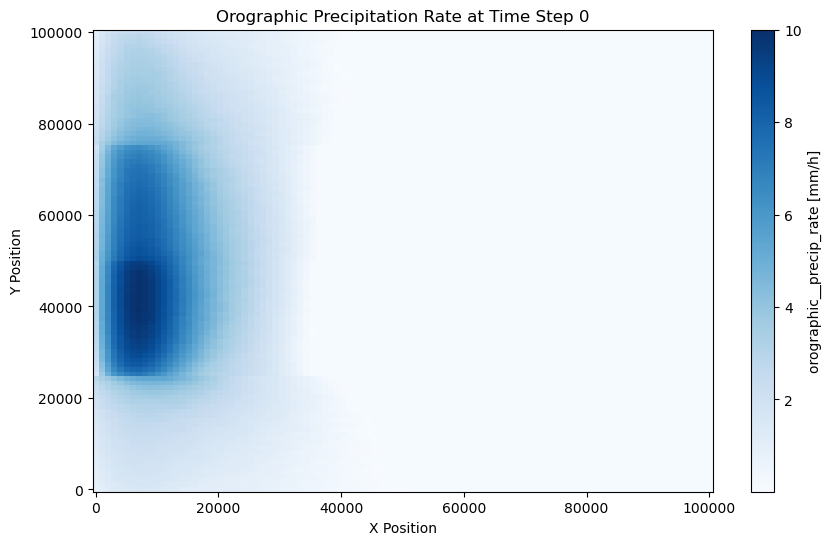

In [20]:
time_step = 0  # Example time step
precip_rate = out_ds_S1['orographic__precip_rate'].isel(time=time_step)

plt.figure(figsize=(10, 6))
precip_rate.plot(cmap='Blues')
plt.title(f'Orographic Precipitation Rate at Time Step {time_step}')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


In [21]:
import plotly.graph_objects as go
import numpy as np

# Select data at a specific time step
time_step = 100
elevation = out_ds_S1['topography__elevation'].isel(time=time_step).values

# Create a 3D surface plot
x = np.arange(elevation.shape[1])
y = np.arange(elevation.shape[0])
X, Y = np.meshgrid(x, y)

fig = go.Figure(data=[go.Surface(z=elevation, x=X, y=Y)])
fig.update_layout(
    title=f'Topography Surface at Time Step {time_step}',
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Elevation'
    )
)
fig.show()

In [22]:
import numpy as np

# Define lapse_rate values to test between -4.9 and -5.8
lapse_rate_values = np.linspace(-4, -7, 6)  # From -4.9 to -5.8 in 6 steps

print(lapse_rate_values)


[-4.  -4.6 -5.2 -5.8 -6.4 -7. ]


Running simulation for lapse_rate = -4.0


             0% | initialize 

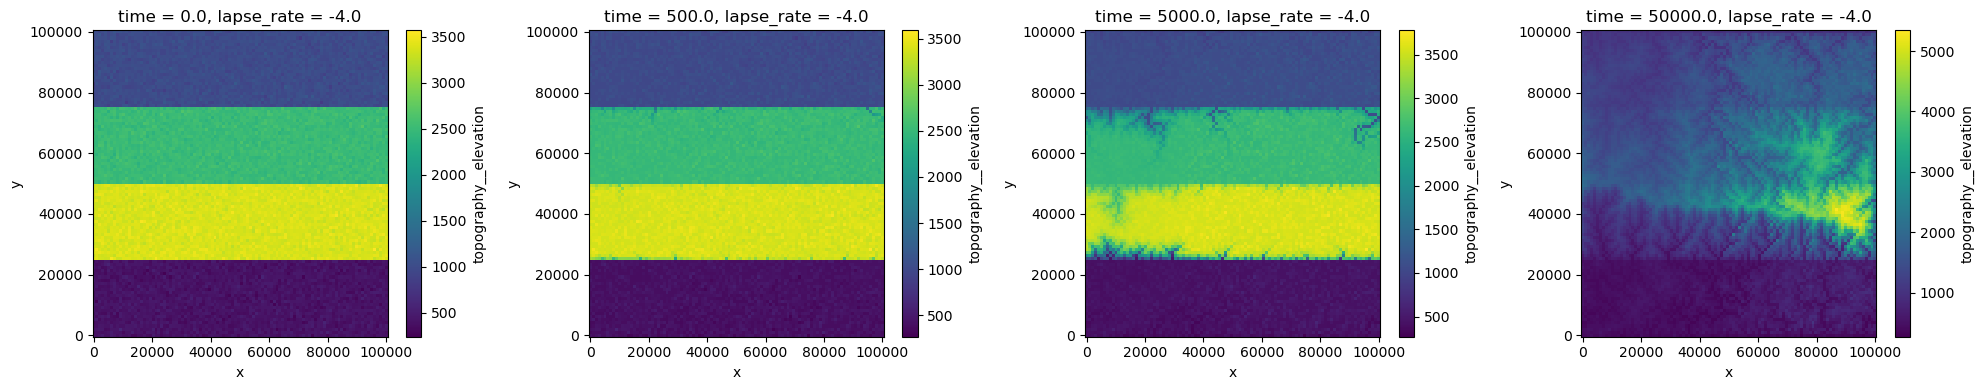

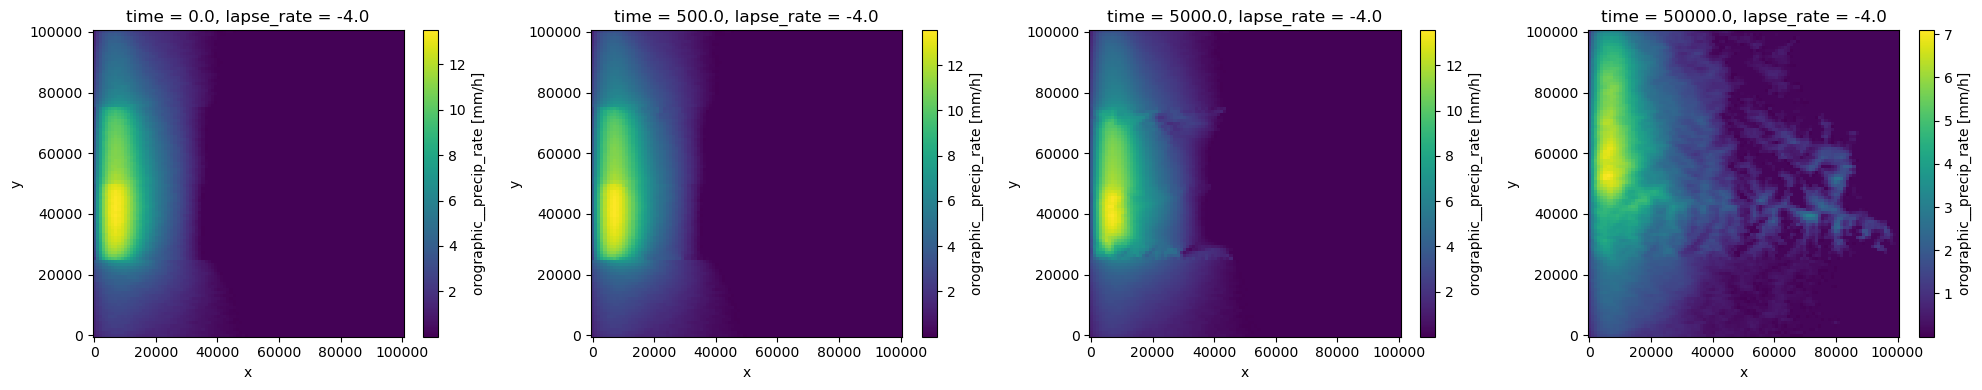

Running simulation for lapse_rate = -4.6


             0% | initialize 

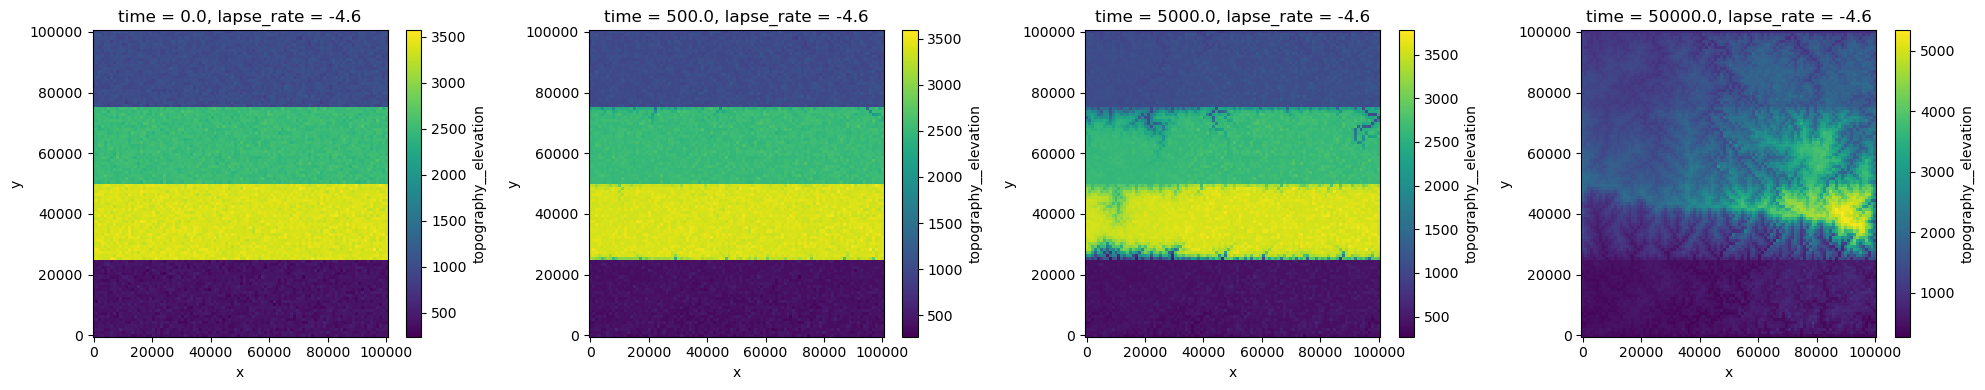

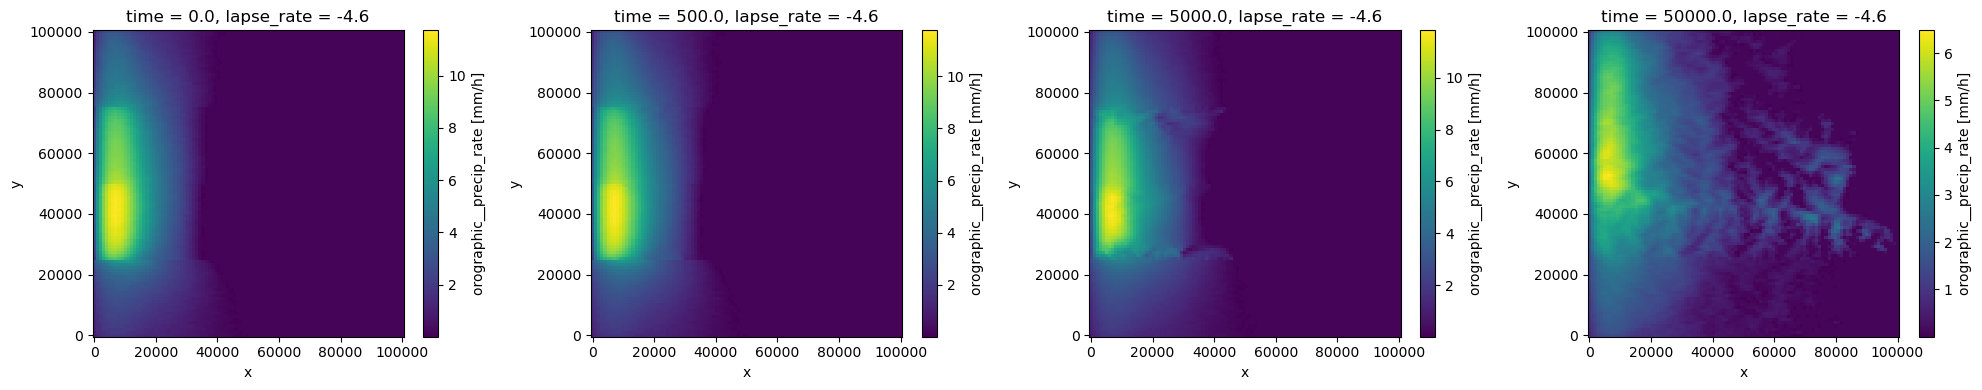

Running simulation for lapse_rate = -5.2


             0% | initialize 

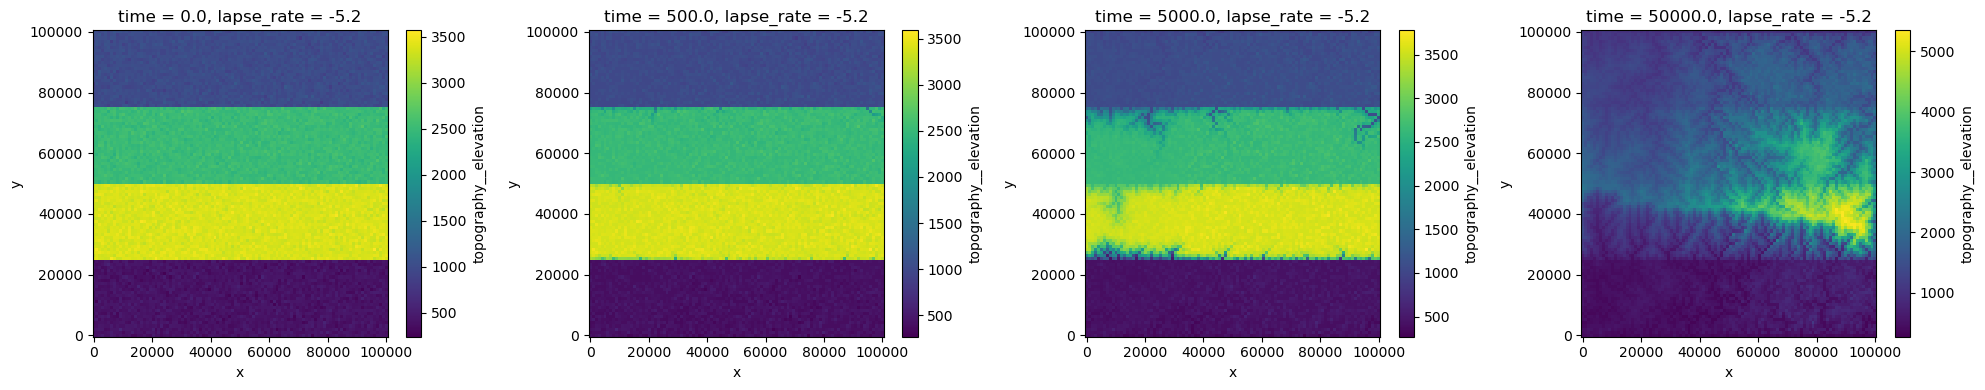

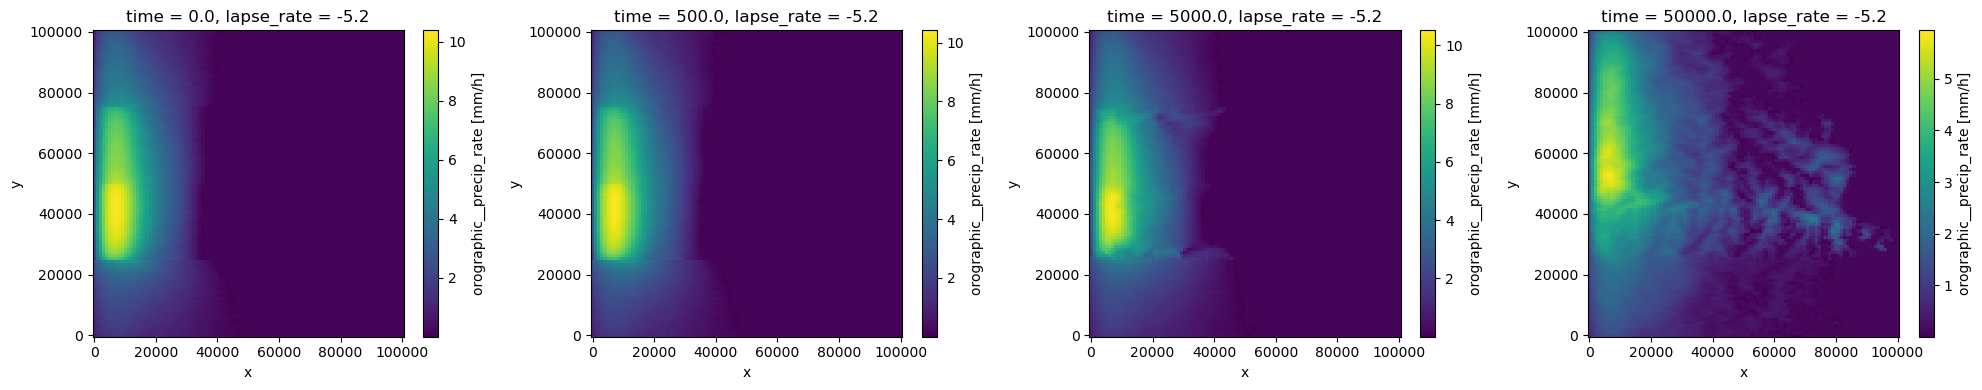

Running simulation for lapse_rate = -5.8


             0% | initialize 

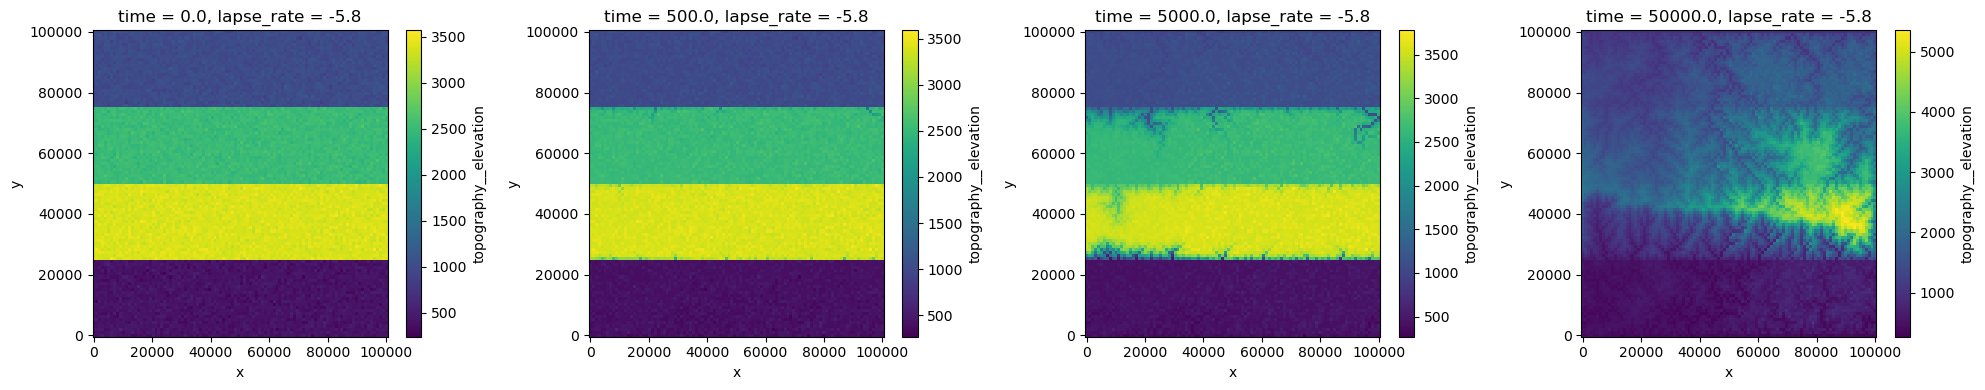

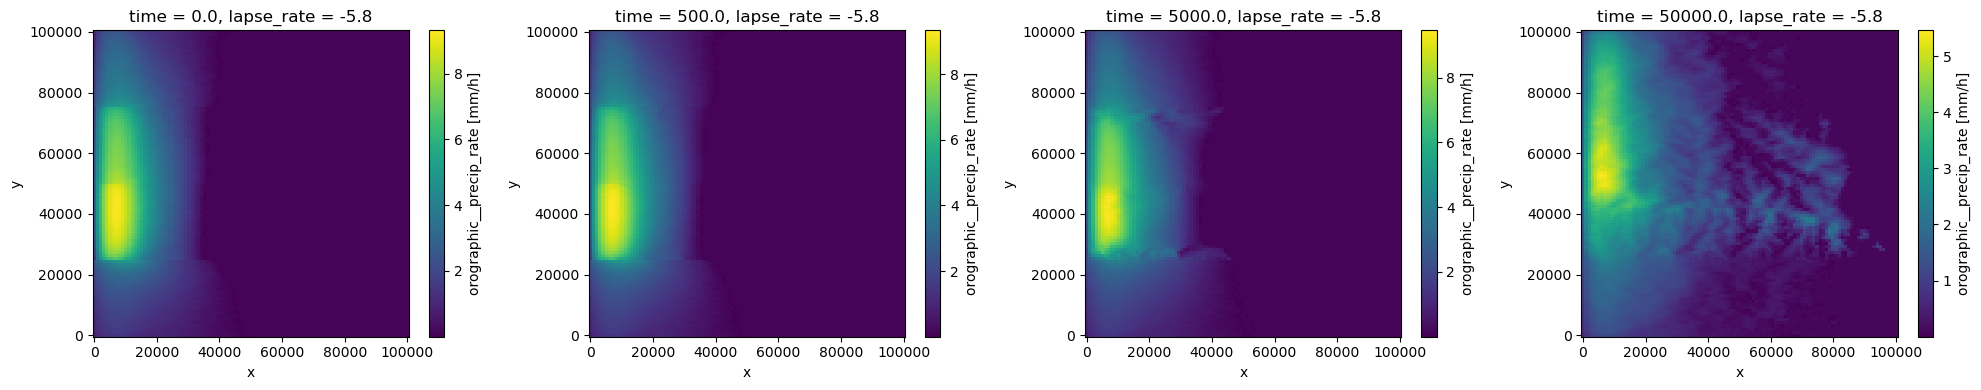

Running simulation for lapse_rate = -6.4


             0% | initialize 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import xsimlab as xs

# Define lapse_rate values to test
lapse_rate_values = np.linspace(-4, -7, 6)

# Loop through lapse_rate values
for lapse_rate in lapse_rate_values:
    print(f"Running simulation for lapse_rate = {lapse_rate}")

    # Set up the model with the current lapse_rate
    in_ds_S1 = xs.create_setup(
        model=SouthernAndesLEM,
        clocks={
            'time': ModelTime_1,
            'output': ModelTime_1[::PlotStep]
        },
        master_clock='time',
        input_vars={
            'grid': {
                'shape': [nx, ny],
                'length': [xl, yl],
            },
            'boundary': {
                'status': BoundaryCondition
            },
            'topography': {
                'elevation': InitialTopography_2D,
            },
            'bedrock': {
                'elevation': InitialTopography_2D,
            },
            'uplift': {
                'rate': UpliftRates_2D,
            },
            'spl': {
                'k_coef': k_coef,
                'area_exp': area_exp,
                'slope_exp': slope_exp,
            },
            'diffusion': {
                'diffusivity': diffusion_diffusivity,
            },
            'orographic': {
                'lapse_rate': lapse_rate,
                'lapse_rate_m': lapse_rate_m,
                'ref_density': ref_density,
                'rainfall_frequency': rainfall_frequency,
                'latitude': latitude,
                'precip_base': precip_base,
                'wind_speed': wind_speed,
                'wind_dir': wind_dir,
                'precip_min': precip_min,
                'conv_time': conv_time,
                'fall_time': fall_time,
                'nm': nm,
                'hw': hw,
            },
        },
        output_vars={
            'topography__elevation': 'time',
            'orographic__precip_rate': 'time'
        }
    )
    
    # Run the simulation
    with xs.monitoring.ProgressBar():
        out_ds_S1 = in_ds_S1.xsimlab.run(model=SouthernAndesLEM)

    # Extract elevation data
    elevation_data = out_ds_S1.topography__elevation.isel(time=[0, 1, 10, 100])

    # Create plots for the current lapse_rate
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    for i, ax in enumerate(axes):
        elevation_data.isel(time=i).plot(ax=ax)
        ax.set_title(f"time = {elevation_data.time[i].values}, lapse_rate = {lapse_rate}")
    plt.tight_layout()
    plt.savefig(f"elevation_lapse_rate_{lapse_rate:.2f}.png")  # Save plots for this lapse_rate
    plt.show()
    
    # Optional: Plot precipitation rate if required
    precip_data = out_ds_S1.orographic__precip_rate.isel(time=[0, 1, 10, 100])
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    for i, ax in enumerate(axes):
        precip_data.isel(time=i).plot(ax=ax)
        ax.set_title(f"time = {precip_data.time[i].values}, lapse_rate = {lapse_rate}")
    plt.tight_layout()
    plt.savefig(f"precip_rate_lapse_rate_{lapse_rate:.2f}.png")  # Save precipitation plots
    plt.show()

In [ ]:
#3D Topographic Plots
import numpy as np
import plotly.graph_objects as go
import xsimlab as xs
import hvplot.xarray

# Define lapse_rate values to test between -4.9 and -5.8
lapse_rate_values = np.linspace(-4, -7, 6)

# Initialize a list to store results
spatial_elevation_results = []  # Store the 2D elevation grids for each lapse rate

# Loop through lapse_rate values
for lapse_rate in lapse_rate_values:
    # Set up the model with the current lapse_rate
    in_ds_S1 = xs.create_setup(
        model=SouthernAndesLEM,
        clocks={
            'time': ModelTime_1,
            'output': ModelTime_1[::PlotStep]
        },
        master_clock='time',
        input_vars={
            'grid': {
                'shape': [nx, ny],
                'length': [xl, yl],
            },
            'boundary': {
                'status': BoundaryCondition
            },
            'topography': {
                'elevation': InitialTopography_2D,
            },
            'bedrock': {
                'elevation': InitialTopography_2D,
            },
            'uplift': {
                'rate': UpliftRates_2D,
            },
            'spl': {
                'k_coef': k_coef,
                'area_exp': area_exp,
                'slope_exp': slope_exp,
            },
            'diffusion': {
                'diffusivity': diffusion_diffusivity,
            },
            'orographic': {
                'lapse_rate': lapse_rate,  # Update only lapse_rate
                'lapse_rate_m': lapse_rate_m,
                'ref_density': ref_density,
                'rainfall_frequency': rainfall_frequency,
                'latitude': latitude,
                'precip_base': precip_base,
                'wind_speed': wind_speed,
                'wind_dir': wind_dir,
                'precip_min': precip_min,
                'conv_time': conv_time,
                'fall_time': fall_time,
                'nm': nm,
                'hw': hw,
            },
        },
        output_vars={
            'topography__elevation': 'time',
            'orographic__precip_rate': 'time'
        }
    )
    
    # Run the simulation
    with xs.monitoring.ProgressBar():
        out_ds_S1 = in_ds_S1.xsimlab.run(model=SouthernAndesLEM)
    
    # Extract the final elevation grid (2D array) for the last timestep
    elevation = out_ds_S1['topography__elevation'].isel(time=-1).values  # 2D array
    spatial_elevation_results.append(elevation)  # Store the grid

    # Create a 3D surface plot for the current lapse_rate
    x = np.arange(elevation.shape[1])
    y = np.arange(elevation.shape[0])
    X, Y = np.meshgrid(x, y)

    fig = go.Figure(data=[go.Surface(z=elevation, x=X, y=Y)])
    fig.update_layout(
        title=f'Topography Surface at Lapse Rate {lapse_rate:.2f}',
        scene=dict(
            xaxis_title='X Position',
            yaxis_title='Y Position',
            zaxis_title='Elevation'
        )
    )
    
    # Show the 3D plot
    fig.show()

    # Add hvplot visualization
hvplot_image = out_ds_S1.topography__elevation.hvplot.image(
    x='x', y='y', cmap='viridis', groupby='time'
)
hvplot_image.opts(title=f'HvPlot Image at Lapse Rate {lapse_rate:.2f}')

# Display the HvPlot visualization
hvplot_image

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

BokehModel(combine_events=True, render_bundle={'docs_json': {'30f2e281-19b4-434e-abe7-db2e33eb1781': {'version…

Running simulation for lapse_rate = -4.0
